# Project 2 report

Github repository: https://github.com/pp-22/pp-project-2-group-2

---
## Task 1: Data cleaning

There are measurement errors in the fare amount and the duration of the trips.

The following method removes data based on fare amount and duration of trips given certain percentiles

---
🚩 ***Task 1:*** `clean_data(date_frame, prc_low, prc_high)` which takes 3 inputs:

- `data_frame` is the pandas dataframe produced by `get_taxi_data()` function,
- `prc_low` and `prc_high` are two numbers such that $0\leq$ `prc_low` $<$ `prc_high` $\leq 100$.

The function should return a cleaned data frame, which is determined from the original data frame where all the measurements below the `prc_low`th percentile and above the `prc_high`th percentile of the fare amount and duration data have been removed.

Columns `tpep_pickup_datetime`, `tpep_dropoff_datetime`, `fare_amount`, and `passenger_count`and must be included in the input of the function.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import get_taxi_data
from scipy.interpolate import interp1d
import seaborn as sns
import warnings
import geopandas as gp
warnings.filterwarnings("ignore")

In [2]:
def clean_data(data_frame, prc_high, prc_low):
    '''
    Returns data that has been cleaned by percentiles prc_high and prc_low based on the duration of the trips and the fare amount

    Input:
        data_frame (pandas data frame): A data frame returned from get_taxi_data(), which includes the columns fare_amount,
                                        tpep_dropoff_datetime and tpep_pickup_datetime columns
        prc_low (float): Low percentiles to be exlcuded from the data
        prc_high (float): High percentiles to be excluded from the data
    
    Output:
        data_frame (pandas data frame): The same data frame is returned where extreme values at prc_high and prc_low are excluded                                  
    '''

    if 'tpep_pickup_datetime' not in data_frame.columns or 'tpep_dropoff_datetime' not in data_frame.columns  or 'trip_distance' not in data_frame.columns or 'PULocationID' not in data_frame.columns or 'DOLocationID' not in data_frame.columns:
        raise NameError("Please ensure that the columns tpep_pickup_datetime, tpep_dropoff_datetime, fare_amount, passenger_count, trip_distance, PULocationID, DOLocationID are included in the data frame")


    # Clean the data based on the following columns
    df_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime','trip_distance','PULocationID', 'DOLocationID']

    # Look through each of the defined columns
    for i in range(len(df_columns)):
        # Determine the high and low percentile for the column
        prc_high_col = data_frame[df_columns[i]].quantile(prc_high)
        prc_low_col = data_frame[df_columns[i]].quantile(prc_low)

        # Drop all the values outside the percentile range
        data_frame = data_frame.drop(data_frame[(data_frame[df_columns[i]] < prc_low_col) | (data_frame[df_columns[i]] > prc_high_col)].index)
    
    # Create a duration column
    data_frame['duration'] = data_frame['tpep_dropoff_datetime'] - data_frame['tpep_pickup_datetime']
    # Determine the high and low percentile for the duration
    dur_prc_high = data_frame['duration'].quantile(prc_high)
    dur_prc_low = data_frame['duration'].quantile(prc_low)
    # Drop all the values outside the percentile range
    data_frame = data_frame.drop(data_frame[(data_frame.duration < dur_prc_low) | (data_frame.duration > dur_prc_high)].index)

    # Sort all the data
    data_frame = data_frame.sort_values(by='tpep_pickup_datetime')

    return data_frame.reset_index(drop=True)

cols_to_read_yellow = ['tpep_pickup_datetime',
                'tpep_dropoff_datetime',
                'trip_distance',
                'PULocationID',
                'DOLocationID']

cols_to_read_green = ['lpep_pickup_datetime',
                    'lpep_dropoff_datetime',
                    'trip_distance',
                    'PULocationID',
                    'DOLocationID']

df_yellow = get_taxi_data('2022', '01', 'yellow', columns=cols_to_read_yellow, save=True)
df_green1 = get_taxi_data('2022', '01', 'green', columns=cols_to_read_green, save=True)

# rename the green taxi columns 
df_green = df_green1.rename(columns={'lpep_pickup_datetime': 'tpep_pickup_datetime',
                              'lpep_dropoff_datetime': 'tpep_dropoff_datetime'})

# combine the yellow taxi columns
df = pd.concat([df_yellow, df_green])
new_df = clean_data(df, 0.99995,0.00005)
new_df


File not in current folder; trying to download data...


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,PULocationID,DOLocationID,duration
0,2022-01-01 00:04:04,2022-01-01 00:33:15,7.60,68,168,0 days 00:29:11
1,2022-01-01 00:04:06,2022-01-01 00:30:36,4.00,161,226,0 days 00:26:30
2,2022-01-01 00:04:07,2022-01-01 00:24:22,3.47,90,142,0 days 00:20:15
3,2022-01-01 00:04:10,2022-01-01 00:20:29,7.82,138,255,0 days 00:16:19
4,2022-01-01 00:04:14,2022-01-01 00:26:12,10.83,132,129,0 days 00:21:58
...,...,...,...,...,...,...
2525221,2022-01-31 23:55:05,2022-02-01 00:06:04,3.70,79,141,0 days 00:10:59
2525222,2022-01-31 23:55:07,2022-02-01 00:03:13,2.52,68,143,0 days 00:08:06
2525223,2022-01-31 23:55:12,2022-02-01 00:01:49,1.19,48,186,0 days 00:06:37
2525224,2022-01-31 23:55:22,2022-02-01 00:00:28,1.06,233,141,0 days 00:05:06


---
## Task 2: Working Days

Rush hour will only occur on working days. Therefore it is necessary to only include business days, Mondays to Fridays (not including bank holidays), to ensure a more accurate and efficient measurment of the data.

---
🚩 ***Task 2:*** `working_days(df, start_time, end_time)` which takes 3 inputs:

- `df` which is a pandas data frame returned by the function `get_taxi_data()`
- `start_time` which is a datetime or np.datetime64 object, that denotes the beginning of the time interval to investigate
- `end_time` which is a datetime or np.datetime64 object, that denotes the end of the time interval to investigate

The function should return a data frame that only includes weekdays (Monday to Friday) and only includes times in the time interval specified by `start_time` and `end_time`. Exceptions are thrown for different of cases of users entering the incorrect start and end times.

Note that if the time interval selected falls over a weekend an exception will be raised even if the start and end times are weekdays. For example, if you select a time on Friday till a time next Monday, this will raise an exception

In [3]:
def working_days(df, start_time, end_time):
    '''
    Returns a new data frame for a selected time period on a workday

    Input:
        df (pandas data frame): A data frame returned from get_taxi_data(), which includes the columns fare_amount,
                                tpep_dropoff_datetime and tpep_pickup_datetime columns
        start_time (datetime or datetime64): The start of the time period the individual wishes to investigate
        end_time (datetime or datetime64): The end of the time period the individual wishes to investigate

    Output:
        reduced_df: A data frame that only contains the data between the selected start and end time on a weekday
    '''

    # Check if the data frame has the correct columns 
    if 'tpep_pickup_datetime' not in df.columns or 'tpep_dropoff_datetime' not in df.columns:
        raise NameError("Please ensure that the columns tpep_pickup_datetime and tpep_dropoff_datetime are included in the data frame")

    # Create a new series that determines the day of the week (0 meaning Monday and 6 meaning Sunday) and make it a column in the data frame
    result = df['tpep_pickup_datetime'].dt.dayofweek
    df['day_of_week'] = result

    # Only keep data that occurs on a Monday to a Friday
    df = df.drop(df[df['day_of_week'] >= 5].index)
    df = df.reset_index(drop=True)

    # Determine the minimum and maximum pickup times
    minimum = df['tpep_pickup_datetime'].min()
    maximum = df['tpep_pickup_datetime'].max()

    # Check if the start_time or end_time entered by the user is beyond the current date and times we are looking at
    if start_time < minimum or end_time > maximum:
        raise IndexError(f"Please enter a date and time between {minimum} and {maximum}")

    # Reduce the data frame to only look at time period that the user has request
    reduced_df = df[(df['tpep_pickup_datetime'] >= start_time) & (df['tpep_dropoff_datetime'] <= end_time)].reset_index(drop=True)

    # If the user entered a date that is on a weekend then let them know to select a weekday
    if reduced_df.empty:
        raise ValueError("You have selected a Saturday or a Sunday, or inputed a start time greater than your end time, please select a weekday and check that your tiem choices are appropriate.")

    return reduced_df

## Topic 1: Demonstrating Rush Hour

Firstly, we would like to see the rush hour in the entire Manhattan area.

🚩 ***Visualisation 1:*** 

In the following code, we first find the location ids for each zone based on the New York taxi zone table, then filter the zones and clean the data to get the pickup and drop-off locations that are in Manhattan.

Data are selected from January 10, 2022 to January 15, 2022, which also happens to be Monday to Friday, and extracted the time and distance on the road for each trip to calculate the speed for this section of the journey, combined with the pick up time, so as to draw the speed for different time periods. To make the speed display more accurate, we used the interpolation and rolling method from project1 to obtain the average speed in each hour, and each interpolation was calculated in five-minute increments.

We know that the lower the speed during a certain period, the more congested the traffic is, which is also known as rush hour, and the chart below shows the rush hour for each day of the week.

In [4]:
# read the csv data into dataframe
area = pd.read_csv('taxi+_zone_lookup.csv')
# use unique zone name to create a list
area_list = area['Borough'].unique()
# define a new dictionary
loc_dict = dict()
for i in area_list:
    # find the corresponding location id for each area
    Location = area[area['Borough']==i]['LocationID'] 
    loc_dict[i]=np.array(Location) # change to list into array
loc_dict #show the dictionary

{'EWR': array([1]),
 'Queens': array([  2,   7,   8,   9,  10,  15,  16,  19,  27,  28,  30,  38,  53,
         56,  57,  64,  70,  73,  82,  83,  86,  92,  93,  95,  96,  98,
        101, 102, 117, 121, 122, 124, 129, 130, 131, 132, 134, 135, 138,
        139, 145, 146, 157, 160, 171, 173, 175, 179, 180, 191, 192, 193,
        196, 197, 198, 201, 203, 205, 207, 215, 216, 218, 219, 223, 226,
        252, 253, 258, 260]),
 'Bronx': array([  3,  18,  20,  31,  32,  46,  47,  51,  58,  59,  60,  69,  78,
         81,  94, 119, 126, 136, 147, 159, 167, 168, 169, 174, 182, 183,
        184, 185, 199, 200, 208, 212, 213, 220, 235, 240, 241, 242, 247,
        248, 250, 254, 259]),
 'Manhattan': array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
         79,  87,  88,  90, 100, 103, 104, 105, 107, 113, 114, 116, 120,
        125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153,
        158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224,
        229,

In [5]:
def datetime_to_seconds(times):
    return (times - times[0]) / np.timedelta64(1, 's')

def seconds_to_datetime(seconds_elapsed, start_time):
    return seconds_elapsed * np.timedelta64(1, 's') + start_time

def generate_interpolated_speed(times, speed, time_delta):
    '''
    Return two vectors times_interp and speed_interp of interpolated
    
    input:
    times(datetime64[s]): the time corresponding to heartbeat
    speed(float): containing the instantaneous speed, miles per hours
    time_delta (imedelta64[s]):  representing a time interval in seconds
    
    Output:
    times_interp(datetime64[s]): contains regularly spaced datetime64[s] timestamps,
    starting at times[0], ending on or less than time_delta seconds before times[-1],
    and with an interval of time_delta between consecutive times.
    speed_interp(float): contains the speed obtained using linear interpolation 
    and evaluated at each time in times_interp.
    
    '''
    # get the time elapsed by substracting the last time to first time
    time_elapsed = times[-1]-times[0]
    # get the seconds of interval
    seconds = time_elapsed / np.timedelta64(1, 's')
    # create an array to store the equal interval of all seconds
    seconds_elapsed = np.array([i for i in range(0, int(seconds),time_delta)])
    # use function to transform the second to datetime object
    times_interp = seconds_to_datetime(seconds_elapsed, times[0])
    # use linear interpolation get the speed function
    f_interp = interp1d(datetime_to_seconds(times), speed)
    # use above function to get the speed
    speed_interp = f_interp(datetime_to_seconds(times_interp))
    
    #return the output
    return times_interp, speed_interp

In [6]:
def rolling_average(times, speed, time_delta, window):
    '''
    Return a NumPy vector speed_rolling to get rolling average of the speed
    
    input:
    times(datetime64[s]): the time corresponding to speed
    speed(float): containing the instantaneous speed, miles per hours
    time_delta (timedelta64[s]): representing a time interval in seconds
    window(timedelta64[s]): representing the window duration in seconds
    
    Output:
    speed_rolling(float):containing values for the rolling average of the speed
    over time, with the given window size
    
    '''
    
    # generate interpolated speed data and times
    times_interp, speed_interp = generate_interpolated_speed(times, speed, time_delta)
    # use function to turn the datetime object to float
    seconds = datetime_to_seconds(times_interp)
    # get the number of time in one window
    num_in_window = window//time_delta
    # create a list to store the rolling speed
    speed_rolling = []
    # use loop to append average speed in window into speed_rolling list 
    for i in range(len(seconds)-num_in_window+1):
        speed_window = [] # create a list to store the speed in a window
        for j in range(num_in_window):
            speed_window.append(speed[i+j]) # append the speed into list
        # append the average value in a window into the list 
        speed_rolling.append(np.mean(speed_window)) 
    # transform the list to array and the type to float 
    speed_rolling = np.array(speed_rolling, dtype = float)
    # return the vector 
    return speed_rolling

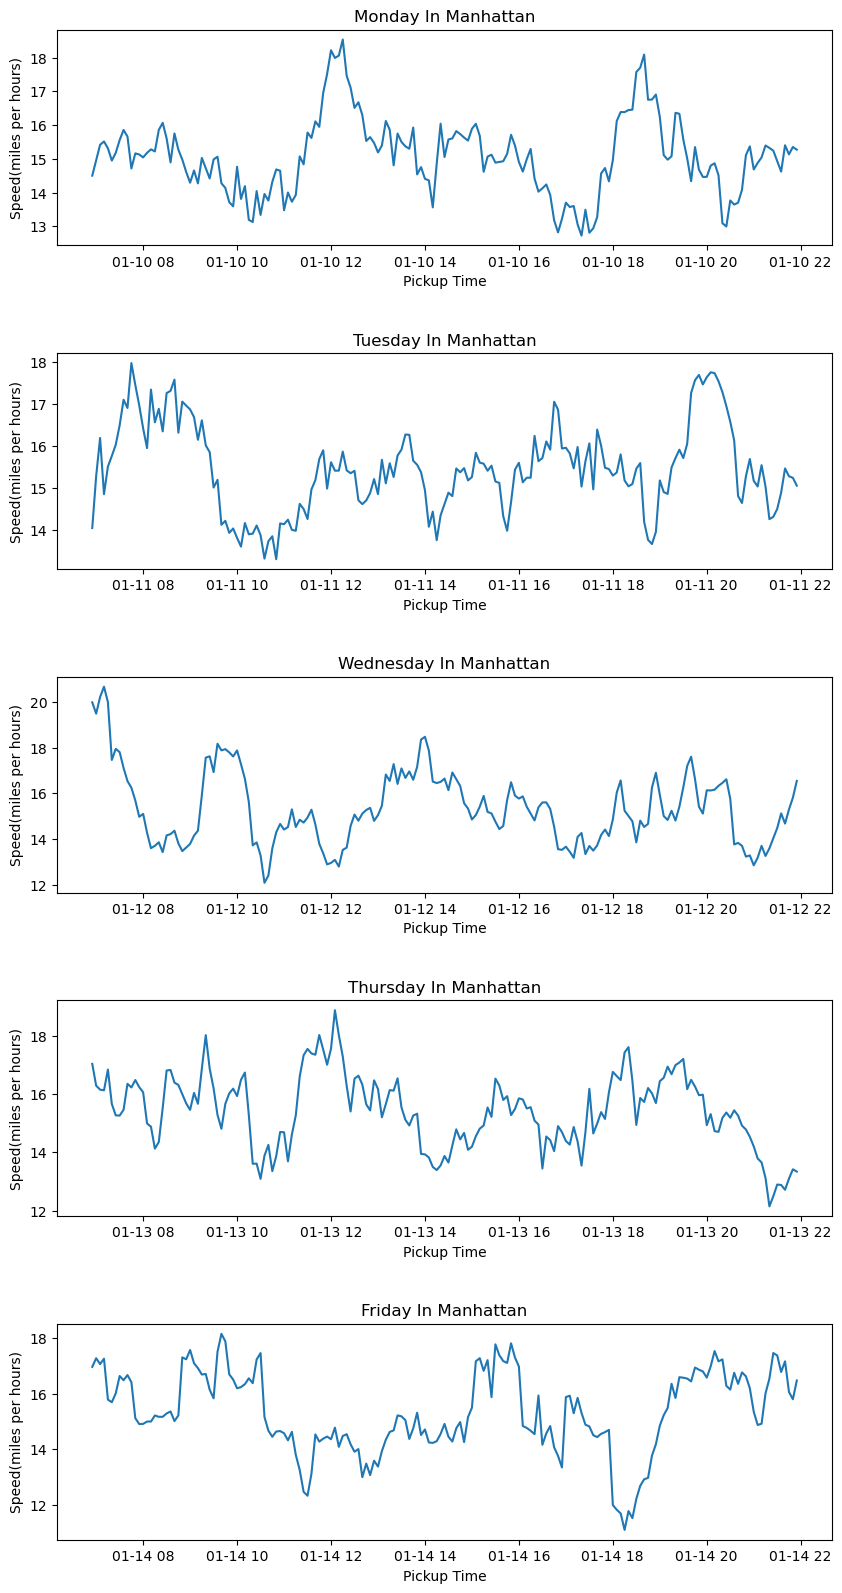

In [7]:
# set the graph structure
fig, ax = plt.subplots(5,1,
                       dpi = 100,figsize = (10,20))
plt.subplots_adjust(hspace=0.5)

# set the dates 
dates = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

i=0 # set the initial value for graph
# use data of 2022-1-10~2022.1.15
for k in range(10,15):    
    # set the begin time and end time
    begin = np.datetime64('2022-01-' + str(k) + 'T06:00')
    end = np.datetime64('2022-01-' + str(k) + 'T22:00')
    # get the dataframe with usefual columns
    df_time = working_days(new_df,begin,end)
    
    # ensure the pick up location and drop locatiion in the same area
    manhattan = loc_dict['Manhattan']
    df_time = df_time.loc[df_time['PULocationID'].isin(manhattan)]
    df_time = df_time.loc[df_time['DOLocationID'].isin(manhattan)]
    
    # clean the distance which equal to 0
    df_time = df_time[df_time['trip_distance']!=0]
    
    # calculate the average speed of each trip
    interval = ((df_time['tpep_dropoff_datetime']-df_time['tpep_pickup_datetime'])/np.timedelta64(1,'h'))
    speed = np.array(df_time['trip_distance']/ interval)
    df_time['speed'] = speed
    
    # clean the speed equal to inf
    df_time  = df_time[df_time['speed']!=np.inf]
    
    # convert the series to array
    times = np.array(df_time['tpep_pickup_datetime'])
    df_speed = np.array(df_time['speed'])
    
    # get the interpolated speed and then get rolling data
    times_interp, speed_interp = generate_interpolated_speed(times, df_speed, 300)
    speed_rolling = rolling_average(times, df_speed, 300 , 3600)
    
    # plot the speed by each weekday
    ax[i].plot(times_interp[-len(speed_rolling):],speed_rolling)
    # set the label
    ax[i].set_xlabel('Pickup Time')
    ax[i].set_ylabel('Speed(miles per hours)')
    # set the title
    ax[i].set_title(dates[i] + ' In Manhattan')
    #iter the index
    i = i+1 


Since the average speed is used to define the rush hour, we can see that the y-axis has a smaller range of fluctuations. We sampled from the 10th-15th of 2022, and since the variation varies greatly from day to day, I will only analyse the rush hour for these five days based on the images.

The lowest point of speed corresponds to the rush hour of each day.

Monday: rush hour occurs at 10am, 5-6pm and 8.30pm

Tuesday: rush hour occurs between 10.30am and 11am

Wednesday: rush hour occurs at around 10.30am

Thursday: rush hour at around 9.30pm

Friday: rush hour at around 6.30pm


🚩 ***Visualisation 2:*** 

In the graph below, I will analyse the rush hour for specific areas of Manhattan during the day.

Firstly, I have divided Manhattan into five zones according to Google Maps: Midtown Manhattan, Upper Manhattan, Upper east side, Upper west side and Lower Manhattan. Since the taxi zone file gives the Manhattan zone as containing islands, we have assigned the island ids to the nearest zones. To make the number of ids in each zone as balanced as possible, the id 43 of Central Park was assigned to Upper west side.


In [8]:
# use the columns we need to create the dataframe
df_id = df_time.reset_index()[['PULocationID','DOLocationID','tpep_pickup_datetime','speed']]
df_id.head()

,PULocationID,DOLocationID,tpep_pickup_datetime,speed
0,137,162,2022-01-14 06:00:11,12.623377
1,151,246,2022-01-14 06:00:14,19.445255
2,239,141,2022-01-14 06:00:16,12.391960
3,143,244,2022-01-14 06:00:25,33.287284
4,68,142,2022-01-14 06:00:28,18.274112


In [9]:
# Partition the Manhattan area into these five zones,
# respectively midtown_manhattan, lower_manhattan, upper_manhattan, 
# upper_east_side and upper_west_side
midtown_manhattan = [ 48,  50,  68,  90, 100, 107, 137, 161, 162, 163,
                     164, 170, 186, 224, 229, 230, 233, 234, 246]
# include three islands
lower_manhattan = [  4,  12,  13,  45,  79,  87,  88, 103, 104, 105, 113, 114, 125, 
                   144, 148, 158, 209, 211, 231, 232, 249, 261] 
# include one island
upper_manhattan = [ 41,  42,  74,  75, 116, 120, 127, 128, 152, 153, 
                   166, 194, 243, 244] 
# include one island
upper_east_side = [140, 141, 202, 236, 237, 262, 263] 
# add the central park id into this list
upper_west_side = [ 24, 43, 142, 143, 151, 238, 239]  

In [10]:
# use a 2d list to store the id of each array
manhattan_area = [midtown_manhattan,upper_manhattan,lower_manhattan,upper_east_side,upper_west_side]
# define area name list
area_name = ['Midtown Manhatten', 'Upper Manhatten', 'Lower Manhatten','Upper east side','Upper west side']

# create two dataframes to store the area name
pick_area = pd.DataFrame()
drop_area = pd.DataFrame()
for i in range(len(manhattan_area)):
    # find the corresponding location id of area
    df_pick  = df_id[df_id['PULocationID'].isin(manhattan_area[i])] 
    df_drop = df_id[df_id['DOLocationID'].isin(manhattan_area[i])]
    # replace the id by area name
    df_pick['PULocationID'] = area_name[i]
    df_drop['DOLocationID'] = area_name[i]
    # merge the dataframe into the main dataframe
    pick_area = pd.concat([pick_area, df_pick])
    drop_area = pd.concat([drop_area, df_drop])

In [11]:
# use area name to replace location id in original dataframe
df_id['PULocationID'] = pick_area.sort_index()['PULocationID']
df_id['DOLocationID'] = drop_area.sort_index()['DOLocationID']
df_id

,PULocationID,DOLocationID,tpep_pickup_datetime,speed
0,Midtown Manhatten,Midtown Manhatten,2022-01-14 06:00:11,12.623377
1,Upper west side,Midtown Manhatten,2022-01-14 06:00:14,19.445255
2,Upper west side,Upper east side,2022-01-14 06:00:16,12.391960
3,Upper west side,Upper Manhatten,2022-01-14 06:00:25,33.287284
4,Midtown Manhatten,Upper west side,2022-01-14 06:00:28,18.274112
...,...,...,...,...
69243,Midtown Manhatten,Midtown Manhatten,2022-01-14 21:57:08,14.025974
69244,Lower Manhatten,Lower Manhatten,2022-01-14 21:57:09,11.220779
69245,Lower Manhatten,Lower Manhatten,2022-01-14 21:57:10,11.368421
69246,Midtown Manhatten,Midtown Manhatten,2022-01-14 21:57:11,12.091603


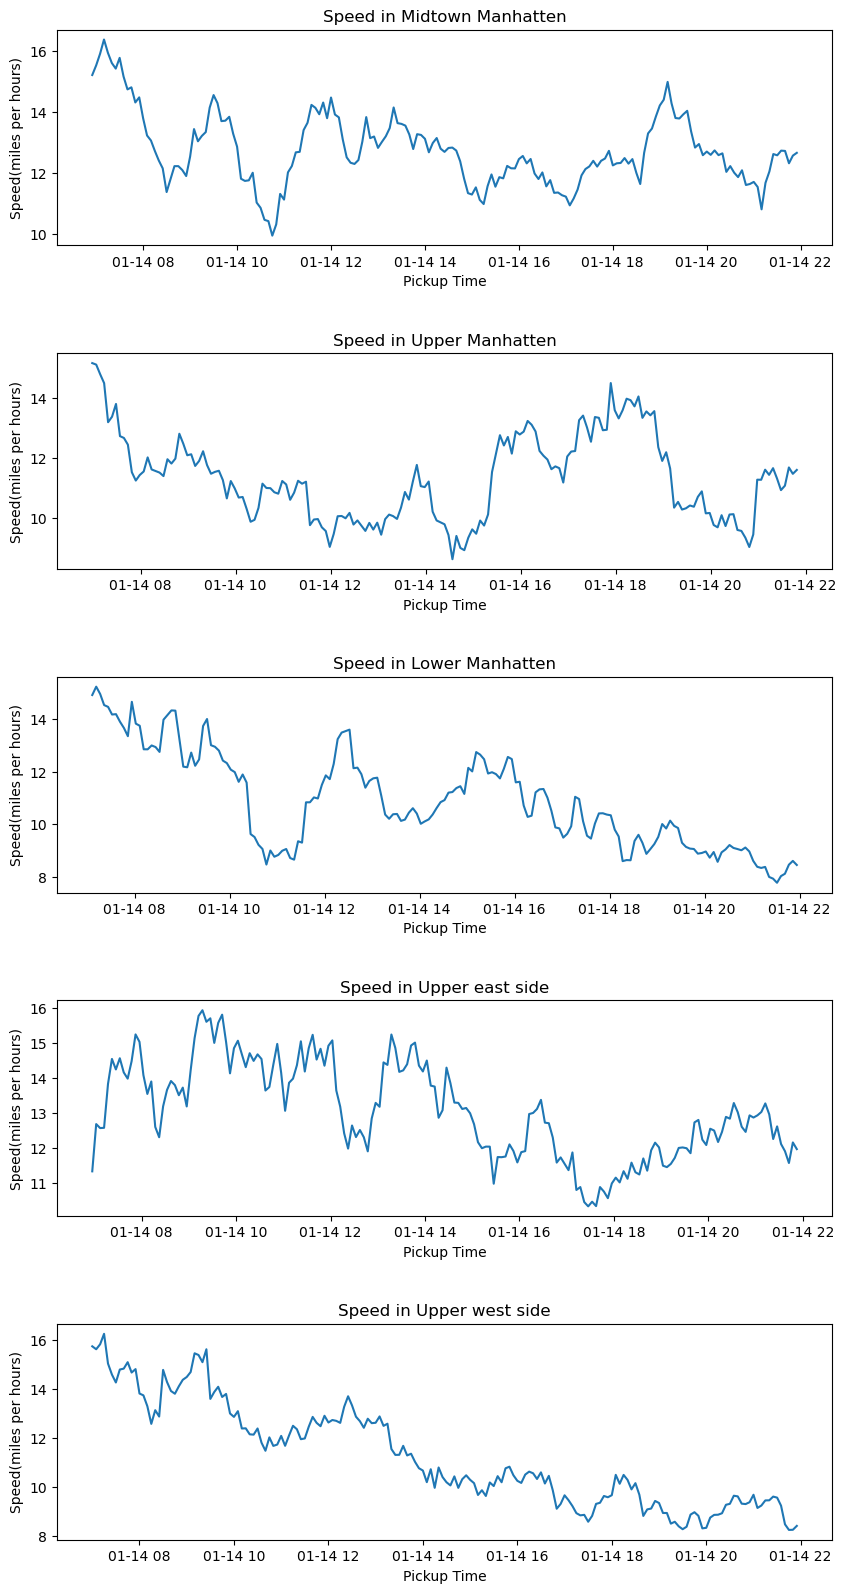

In [12]:
# define the graph structure
fig, ax = plt.subplots(5,1,
                       dpi = 100,figsize = (10,20))
plt.subplots_adjust(hspace=0.5)
# set the start and end time 
start_time = np.datetime64('2022-01-07 06:00:00')
end_time = np.datetime64('2022-01-07 22:00:00')

for i in range(len(area_name)):
    # select the data that the pick up and drop down in the same area
    region = df_id[(df_id['PULocationID'] == area_name[i]) & (df_id['DOLocationID'] 
                                                              == area_name[i])][['tpep_pickup_datetime','speed']]
    # convert to array
    df_speed = np.array(region['speed']) 
    times = np.array(region['tpep_pickup_datetime'])
    # get the interpolated speed data 
    times_interp, speed_interp = generate_interpolated_speed(times, df_speed, 300)
    # calculate the rolling average of speed data 
    speed_rolling = rolling_average(times, df_speed, 300 , 3600)
    # plot the graph 
    ax[i].plot(times_interp[-len(speed_rolling):],speed_rolling) 
    # set the title
    ax[i].set_title(f'Speed in {area_name[i]}')
    # set the label
    ax[i].set_xlabel('Pickup Time')
    ax[i].set_ylabel('Speed(miles per hours)')


Midtown Manhatten: rush hour occurs at 10.30-11:00am

Upper Manhatten: rush hour occurs between 2:30pm

Lower Manhatten: rush hour occurs at around 21:00pm

Upper east side: rush hour at around 5:30pm

Upper west side: rush hour at around 22:00pm


The average speed for each hour is the cumulative distance travelled in that hour divided by the time of the hour. During rush hour, the roads are more congested and show a much smaller average speed. Looking at the line graph of the average speed, we can assume that the trough in speed reflects the rush hour in Manhattan.

We know that midtown contains commercial areas and upper east and upper west contain residential areas. Combining the rush hours for these three locations, we can see that the commercial area has a rush hour at 10.30am, which corresponds to the time when people go to work. The residential area has a rush hour at 5:30 p.m. and 10:00 p.m. respectively, which may be due to the fact that most people go home from work during this time.

## Topic 2: Demonstrating pick up location

Firstly, we would like to see where people in different parts of Manhattan prefer to take a taxi to. This theme could portray the geographical characteristics of Manhattan.




🚩 ***Visualisation 3:*** 

The following code portrays the number of taxi trips between different places, with darker colours representing more taxi records. We can analyse where people tend to take taxis in different areas.

We will use a customised five areas of Manhattan and then create a list of how many times different areas are used as a departure and destination. Finally, we drew a heat map to visually show where people in different parts of Manhattan tend to take taxis to.

In [13]:
# Create a list to record the number of times that different zones were used as origins and destinations.
df_0 = pd.DataFrame(0, index=area_name, columns=area_name)
for i in df_id.index:
    a= df_id.PULocationID[i]
    b= df_id.DOLocationID[i]
    df_0.loc[a,b]+=1
df_0

,Midtown Manhatten,Upper Manhatten,Lower Manhatten,Upper east side,Upper west side
Midtown Manhatten,16072,722,5441,5037,2971
Upper Manhatten,359,1375,76,540,654
Lower Manhatten,3795,116,3569,585,353
Upper east side,4844,1296,928,7246,2306
Upper west side,3067,1135,426,2176,4159


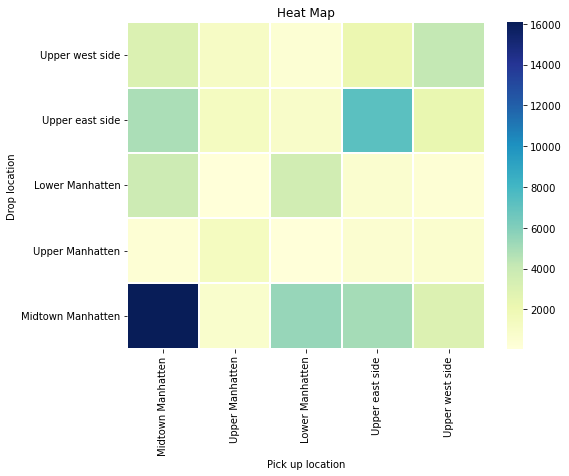

In [14]:
## Draw a heatmap to visualise where people in different areas of Manhattan tend to take taxis
plt.figure(figsize=(8,6))
ax = sns.heatmap( df_0 , cmap="YlGnBu",linewidths=0.2)
ax.invert_yaxis()
plt.title( "Heat Map")
plt.xlabel('Pick up location')
plt.ylabel('Drop location')
plt.show()

The above graph shows that people in midtown are more likely to take a taxi to midtown and upper east, which is shown as a dark colour in the graph. The next obvious thing is that people in the upper east area tend to take a taxi to upper east and midtown. Then we can observe that people in the lower area also tend to take a taxi to midtown. 

We observe that midtown contains commercial areas and upper east and upper west contain residential areas. People in commercial areas tend to go to other areas in greater numbers overall. The number of people from other areas coming to the commercial area is also higher, showing a darker colour in the graph. People in the residential areas, on the other hand, are more likely to take a taxi to move around residential areas.

🚩 ***Visualisation 4:*** 

The following code is to calculate the number of pickups in the three boroughs, respectively Queens, Manhattan and Brooklyn. For fifferent pickup locations, the number of pickups is divided into five equal parts and plotted in different colours, with the darker the location, the more pickups it receives.

In [15]:
# read the geographical data into a dataframe
geo_df = gp.read_file('taxi_zones/taxi_zones.shp')
geo_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [16]:
def find_pick_class(area_name):
    '''
    Returns geographical dataframe with pick up class
    
    Input:
        area_name (string): a zone in Manhatten
    
    Output:
        data_frame (pandas data frame):  geographical dataframe with pick up class
    '''
    area_loc = loc_dict[area_name] # define the id in given area
    area_geo = geo_df[geo_df['borough']==area_name] # select the geo data in given area
    
    # count the number of id as pick up location
    fre_list = []
    for i in area_loc:
        fre = df['PULocationID'].tolist().count(i)
        fre_list.append(fre) #append into a list
    
    # use bin to divdie the frequency into 5 equal interval    
    bins = []
    for i in range(0,6):
        # keep the pick up time to integer
        b = int(np.quantile(fre_list,i/5))
        bins.append(b)
    
    # use cut to get the range of each class
    area_geo['pick_class']=pd.cut(fre_list,bins) 
    # output the dataframe
    return area_geo

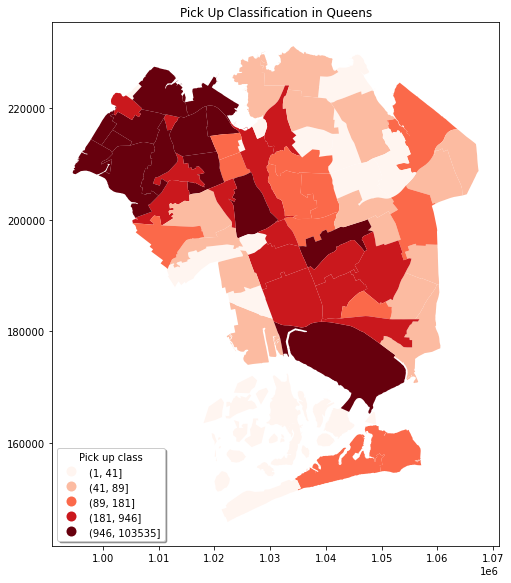

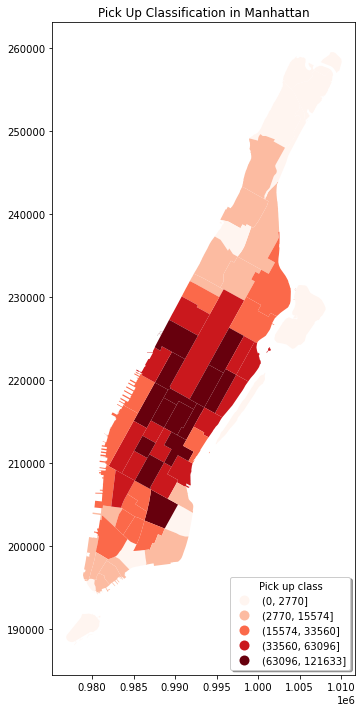

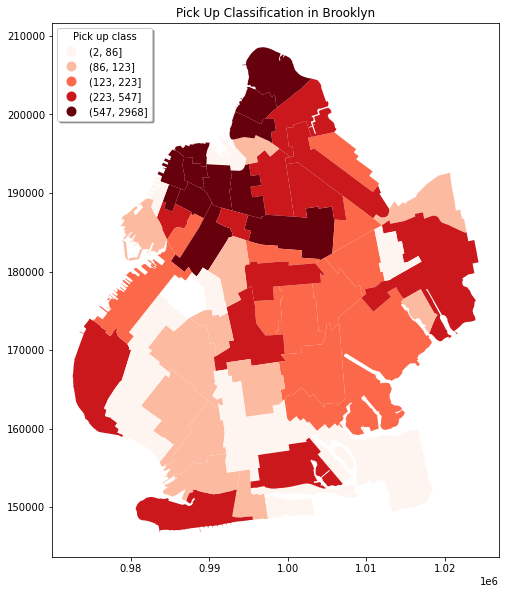

In [17]:
area_list = ['Queens','Manhattan','Brooklyn'] # define the area we want to draw
legend_loc = ['lower left','lower right','upper left'] # define the legend location
for i in range(len(area_list)):
    fig,ax = plt.subplots(figsize=(8,12))
    geo_data= find_pick_class(area_list[i]) # get the  geographical data
    # plot the map with different color, deeper color means more pick up time
    ax= geo_data.plot(ax=ax,column='pick_class',cmap='Reds',legend = True, 
                        legend_kwds={'loc':legend_loc[i],'title':'Pick up class','shadow':True})
    ax.set_title(f'Pick Up Classification in {area_list[i]}') #set the title
    plt.show() #show the graphs

The second set of diagrams portrays areas with a higher number of pick ups in the different administrative districts. In the Queens diagram the pick ups are concentrated in the upper left and lower right areas. In the manhattan diagram, the pick ups are concentrated in the centre. In the Brooklyn map, the pick ups are concentrated in the top left area. The size of the data in the legend shows that manhattan has the largest number of rides, Queens is second and Brooklyn has a significantly smaller number of rides.